In [2]:
!pip install celluloid

MovieWriter imagemagick unavailable; using Pillow instead.


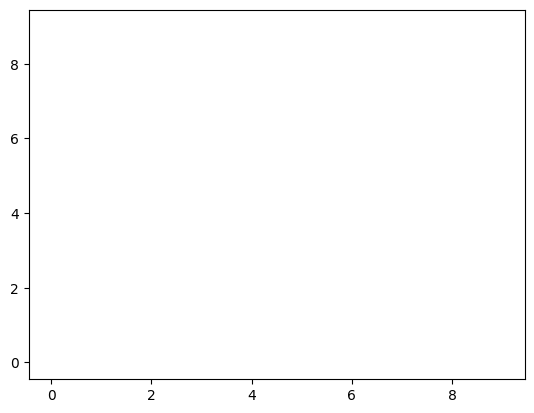

In [3]:
from matplotlib import pyplot as plt
from celluloid import Camera
 
fig = plt.figure()
camera = Camera(fig)
 
for i in range(10):
    plt.plot([i] * 10)
    camera.snap()
 
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer = 'imagemagick')

In [1]:
%load_ext autoreload
%autoreload 2

warrior:  (0, 1.5)
knight:  (0, 1.5)
warrior:  (0, 2.5)
knight:  (0, 2.5)
warrior:  (0, 3.5)
archer:  (0, 3.5)
warrior:  (8, 1.5)
knight:  (8, 1.5)
warrior:  (8, 2.5)
knight:  (8, 2.5)
warrior:  (8, 3.5)
archer:  (8, 3.5)
snap!
snap!
torch.Size([8, 20, 13])


  4%|▍         | 43/1000 [00:04<01:49,  8.75it/s]


KeyboardInterrupt: 

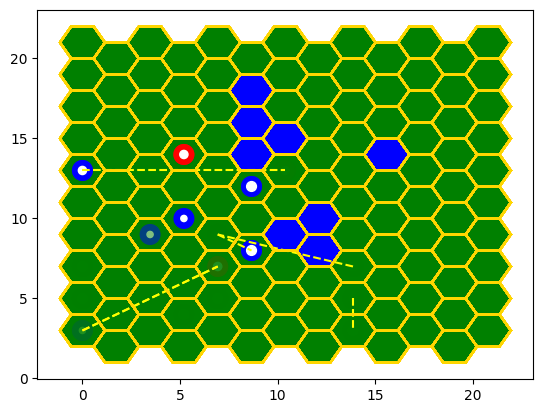

In [27]:
import tqdm

from Game import Game
from objects.Warriors import Archer, Knight
from Brain import ArcherBrain, KnightBrain, PreNet
from graphics.MatplotlibRenderer import MatplotlibRenderer
from map.Map import Map
from Config import Config

m = Map('static/map.json')
teams = [
            [Knight(pos=(0, 1.5)), Knight(pos=(0, 2.5)), Archer(pos=(0, 3.5))], 
            [Knight(pos=(8, 1.5)), Knight(pos=(8, 2.5)), Archer(pos=(8, 3.5))], 
        ]
config = Config('static/config.json')

plt_assets = {
    'surface' : {
        'none'  : {
            'color' : 'white'
        },
        'water' : {
            'color' : 'blue'
        },
        'ground' : {
            'color' : 'brown'
        },
        'grass' : {
            'color' : 'green'
        }
    },
    'warriors': {
        'archer' : 'red',
        'knight' : 'blue'
    }
}

renderer = MatplotlibRenderer(plt_assets)
game = Game(teams, m, config)
# задаём мозги NPC
h, w = game.field.hex_field.get_size()
w, h = int(w), int((h-0.5)*2)+1
prenet = PreNet(h, w)
brain_archer = ArcherBrain(prenet=prenet, return_dist=True)
brain_knight = KnightBrain(prenet=prenet, return_dist=True)

obs = game.reset(max_iter=1000, record=True, renderer=renderer)
dist = brain_knight(obs)
action = dist.sample().argmax()
action = dist.decode_action(action)
game.step(action)

obs = game.reset(max_iter=1000, record=True, renderer=renderer)
print(obs.shape)
for i in tqdm.tqdm(range(1000)):
    dist = None
    match game.warrior.get_info()['class']:
        case 'knight':
            dist = brain_knight(obs)
        case 'archer':
            dist = brain_archer(obs)
    action = dist.sample().argmax()
    action = dist.decode_action(action)
    r, obs, stop = game.step(action)
    if stop == True:
        break
renderer.save()

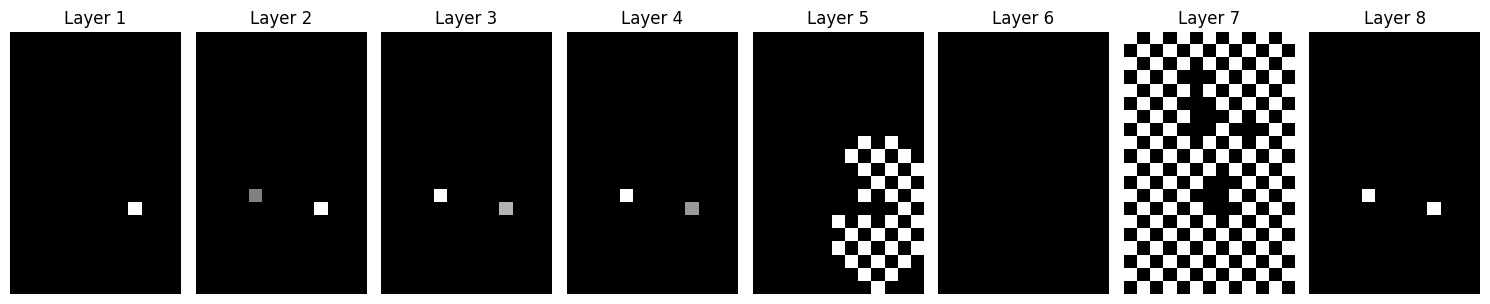

In [13]:
import matplotlib.pyplot as plt

# config = Config('static/config.json')
# game = Game(teams, m, config)
mask = game.observe() # .reset(max_iter=1000, record=False, renderer=None)

num_layers = mask.shape[0]

fig, axes = plt.subplots(1, num_layers, figsize=(15, 5))
for i in range(num_layers):
    axes[i].imshow(mask[i], cmap='gray', interpolation='nearest')
    axes[i].set_title(f'Layer {i + 1}')
    axes[i].invert_yaxis()
    axes[i].axis('off')

plt.tight_layout()

tensor(253) 253 {'type': 'move', 'params': {'pos': (6, tensor(10.5000))}}


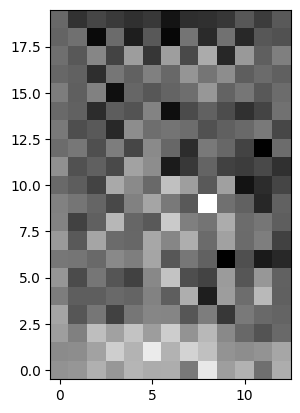

In [15]:
from Brain import ArcherBrain, PreNet, Distribution
import matplotlib.pyplot as plt

h, w = game.field.hex_field.get_size()
w, h = int(w), int((h-0.5)*2)+1
brain = ArcherBrain(prenet=PreNet(h, w), return_dist=True)
dist = brain(game.observe())

plt.imshow(dist.dist['move']['heat_map'].detach().numpy(), cmap='gray', interpolation='nearest')
plt.gca().invert_yaxis()

# res['params']['heat_map'][:10,:10]

action_ind = dist.sample().argmax()
action = dist.decode_action(action_ind)
action_ind_new = dist.encode_action(action)

print(action_ind, action_ind_new, action)

In [21]:
from map.Map import serializable2map, map2serializable
import json


data = []
with open('static/map.copy.json', 'r', encoding='utf-8') as file:
    data = json.load(file)
with open('static/map.json', 'w', encoding='utf-8') as file:
    m = serializable2map(data)
    for k, item in m['surface'].items():
        m['surface'][k]['speed'] = 0. if m['surface'][k]['s_type'] == 'water' else 1.
    m = map2serializable(m)
    json.dump(m, file)

In [3]:
game.warrior_pos

{(0, 1.5), (0.0, 4.5), (0.0, 5.5), (4.0, 1.5), (5.0, 2.0), (8, 1.5)}

# PPO

In [16]:
from training.PolicyValueNetwork import PolicyValueNetwork
# input:
#     states - tensor, (batch_size x features)
# output:
#     distribution
#     V - tensor, critic estimation, (batch_size)

In [ ]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class Policy:
    def __init__(self, model):
        self.model = model.to(device=DEVICE)

    def act(self, inputs, training=False):
        """
        input:
            inputs - numpy array if training is False, otherwise tensor, (batch_size x features)
            training - flag, bool
        output:
            if training is True, dict containing keys ['actions', 'log_probs', 'values']:
                `distribution`
                'values' - critic estimations, tensor, (batch_size)
            if training is False, dict containing keys ['actions', 'log_probs', 'values']:
                'actions' - selected actions, numpy, (batch_size)
                'log_probs' - log probs of selected actions, numpy, (batch_size)
                'values' - critic estimations, numpy, (batch_size)
        """
        # if training is false, input is numpy
        if not training:
            inputs = torch.FloatTensor(inputs).to(DEVICE)

        dist, values = self.model(inputs)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        values = values.flatten()

        if training:
            return {
                "dist": dist,
                "values": values,
            }

        else:
            return {
                "dist": dist,
                "actions": actions.cpu().detach().numpy(),
                "log_probs": log_probs.cpu().detach().numpy(),
                "values": values.cpu().detach().numpy(),
            }

In [59]:
from Brain import ArcherBrain, KnightBrain, ValueNet
from training.GameRunner import GameRunner
from training.PPO import AsArray
from Game import Game

teams = [
            [Knight(pos=(0, 1.5)), Knight(pos=(0, 2.5)), Archer(pos=(0, 3.5))], 
            [Knight(pos=(8, 1.5)), Knight(pos=(8, 2.5)), Archer(pos=(8, 3.5))], 
        ]

config = Config('static/config.json')
game = Game(teams, m, config)
mask = game.reset(max_iter=1000, record=False, renderer=None)

prenet_1 = PreNet(h, w)
prenet_2 = PreNet(h, w)
# пока только 1 мозг учим
brain_1 = ArcherBrain(prenet=prenet_1, return_dist=True)
brain_2 = KnightBrain(prenet=prenet_2, return_dist=True)
value_net_1 = ValueNet(prenet=PreNet(h, w))
value_net_2 = ValueNet(prenet=PreNet(h, w))
model_1 = PolicyValueNetwork(brain_1, value_net_1).to(DEVICE)
model_2 = PolicyValueNetwork(brain_2, value_net_2).to(DEVICE)
policy_1 = Policy(model_1)
policy_2 = Policy(model_1)
game.reset()
runner = GameRunner(game, [policy_1, policy_2], nsteps=10, transforms=[[AsArray()], [AsArray()]])
trajectory = runner.get_next()
print(trajectory.keys())

warrior:  (0, 1.5)
knight:  (0, 1.5)
warrior:  (0, 2.5)
knight:  (0, 2.5)
warrior:  (0, 3.5)
archer:  (0, 3.5)
warrior:  (8, 1.5)
knight:  (8, 1.5)
warrior:  (8, 2.5)
knight:  (8, 2.5)
warrior:  (8, 3.5)
archer:  (8, 3.5)
dict_keys(['actions', 'dist', 'log_probs', 'values', 'observations', 'rewards', 'dones'])


In [53]:
print(type(trajectory['actions']), trajectory['actions'])
print(type(trajectory['dist']), trajectory['dist'].shape)
print(type(trajectory['log_probs']), trajectory['log_probs'])
print(type(trajectory['values']), trajectory['values'])
print(type(trajectory['observations']), trajectory['observations'].shape)
print(type(trajectory['rewards']), trajectory['rewards'])
print(type(trajectory['dones']), trajectory['dones'])
{k: v.shape for k, v in trajectory.items()}

<class 'numpy.ndarray'> [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'> (10,)
<class 'numpy.ndarray'> [-6.2553177 -6.2528334 -6.2536206 -6.255753  -6.253695  -6.2517843
 -6.255905  -6.2526736 -6.2543344 -6.253358 ]
<class 'numpy.ndarray'> [[0.13250495]
 [0.11599534]
 [0.12246536]
 [0.12814988]
 [0.12826592]
 [0.11015482]
 [0.12042543]
 [0.13386177]
 [0.11832295]
 [0.1190463 ]]
<class 'numpy.ndarray'> (10, 8, 20, 13)
<class 'numpy.ndarray'> [-1. -1.  0.  0. -1.  0. -1. -1.  0. -1.]
<class 'numpy.ndarray'> [False False False False False False False False False False]


{'actions': (10, 520),
 'dist': (10,),
 'log_probs': (10,),
 'values': (10, 1),
 'observations': (10, 8, 20, 13),
 'rewards': (10,),
 'dones': (10,)}

In [20]:
from training.GAE import GAE

In [54]:
from training.PPO import Sampler, NormalizeAdvantages, PyTorchify, make_ppo_sampler, PPO

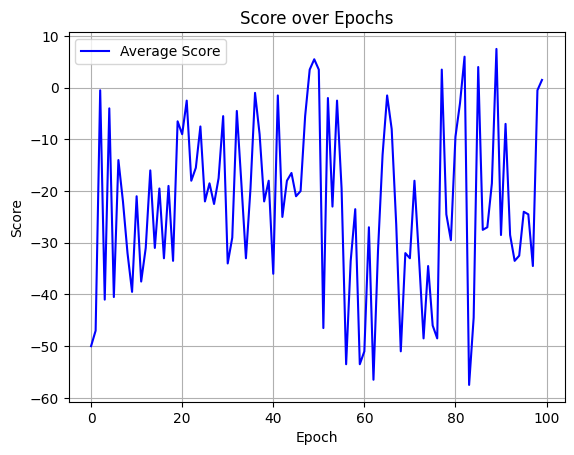

100%|██████████| 100/100 [43:53<00:00, 26.33s/it]


In [66]:
import sys
from IPython.display import clear_output
import numpy as np

def evaluate(env : Game, policy, n_games=1, t_max=1000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        R = [0, 0]
        t = 0
        for _ in range(t_max):
            act = policy[env.team_counter.get()].act(np.array([s]))
            dist, actions = act['dist'], act['actions']
            r, s, done = env.step(dist.decode_action(actions.argmax()))
            R[t] += r
            t = env.team_counter.get()
            if done:
                break
        rewards.append(R[0])
    return np.array(rewards)

def plot_scores(scores):
    plt.clf()  # Clear current figure
    clear_output(True)
    plt.plot(scores, label='Average Score', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Score over Epochs')
    plt.legend()
    plt.grid()
    plt.draw()  # Force redraw
    plt.pause(0.1)  # Process GUI events
    plt.close()  # Close figure to prevent memory leaks

prenet_1 = PreNet(h, w)
prenet_2 = PreNet(h, w)
# пока только 1 мозг учим
brain_1 = ArcherBrain(prenet=prenet_1, return_dist=True)
brain_2 = KnightBrain(prenet=prenet_2, return_dist=True)
value_net_1 = ValueNet(prenet=PreNet(h, w))
value_net_2 = ValueNet(prenet=PreNet(h, w))
model_1 = PolicyValueNetwork(brain_1, value_net_1).to(DEVICE)
model_2 = PolicyValueNetwork(brain_2, value_net_2).to(DEVICE)
policy_1 = Policy(model_1)
policy_2 = Policy(model_1)
sampler = make_ppo_sampler(game, policy_1, policy_2, num_runner_steps=128, num_epochs=5)

# минимизируем лосс
optimizer = torch.optim.AdamW(model_1.parameters(), lr=3e-3, eps=1e-05, maximize=False)
ppo = PPO(policy_1, optimizer, sampler)

import tqdm
NUM_ITERATIONS = 100

plt.ion()
fig = plt.figure(figsize=(10, 5))
scores = []
for iteration in tqdm.tqdm(range(NUM_ITERATIONS)):
    for batch in sampler.get_next():
        # print(batch)
        ppo.step(batch)

    # print("evaluation")
    sessions = evaluate(game, [policy_1, policy_2], n_games=2)
    score = sessions.mean()
    scores.append(score)

    plt.figure(fig.number)  # Используем существующую фигуру
    plot_scores(scores)
    sys.stdout.flush()

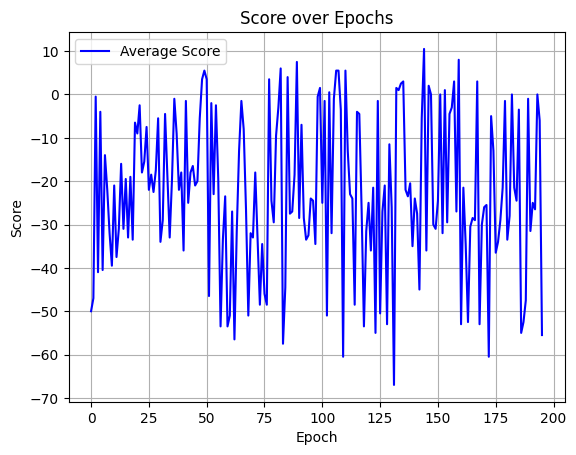

 10%|▉         | 96/1000 [20:42<3:15:04, 12.95s/it] 


KeyboardInterrupt: 

In [67]:
NUM_ITERATIONS = 1000
for iteration in tqdm.tqdm(range(NUM_ITERATIONS)):
    for batch in sampler.get_next():
        # print(batch)
        ppo.step(batch)

    # print("evaluation")
    sessions = evaluate(game, [policy_1, policy_2], n_games=2)
    score = sessions.mean()
    scores.append(score)

    plt.figure(fig.number)  # Используем существующую фигуру
    plot_scores(scores)
    sys.stdout.flush()

In [44]:
evaluate(game, policy, n_games=20)

array([-496, -495, -494, -496, -496, -496, -490, -495, -495, -496, -494,
       -496, -496, -470, -495, -448, -495, -496, -496, -495])

In [130]:
# evaluation will take some time!
sessions = evaluate(game, policy, n_games=20)
score = sessions.mean()
print(f"Your score: {score}")

ValueError: not enough values to unpack (expected 4, got 3)